In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
features = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['Zcross12' 'Zcross13' 'Zcross23' 'maxj' 'maxk' 'maxi1' 'maxi2'
 'maxstrength' 'secondres' 'EMmed12' 'EMmax12' 'EMdrift12'
 'capseculartscale12' 'EMdetrendedstd12' 'EMrollingstd12' 'DiffcoeffEM12'
 'medvarEM12' 'Zmed12' 'Zmax12' 'Zdetrendedstd12' 'Zrollingstd12'
 'DiffcoeffZ12' 'medvarZ12' 'Zcomdrift12' 'Zcomrollingstd12'
 'phiZcomdrift12' 'phiZcomrollingstd12' 'Zstardrift12' 'Zstarrollingstd12'
 'Zcosphistd12' 'medZcosphi12' 'EMmed23' 'EMmax23' 'EMdrift23'
 'capseculartscale23' 'EMdetrendedstd23' 'EMrollingstd23' 'DiffcoeffEM23'
 'medvarEM23' 'Zmed23' 'Zmax23' 'Zdetrendedstd23' 'Zrollingstd23'
 'DiffcoeffZ23' 'medvarZ23' 'Zcomdrift23' 'Zcomrollingstd23'
 'phiZcomdrift23' 'phiZcomrollingstd23' 'Zstardrift23' 'Zstarrollingstd23'
 'Zcosphistd23' 'medZcosphi23' 'tlyap' 'megno']


In [3]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
9994,0009995.bin,9.990000e+08,9.990000e+08,True
9995,0009996.bin,3.814426e+06,6.124299e+06,False
9996,0009997.bin,1.498363e+04,3.320307e+03,False
9997,0009998.bin,9.419807e+05,8.353625e+05,False
9998,0009999.bin,1.895071e+07,2.047024e+07,False


In [30]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

dataset['hasnull'] = dataset.apply(hasnull, axis=1)

In [35]:
nulllabels = labels[(dataset['hasnull'] == 1)]['Stable']
nulllabels.shape

(2357,)

In [36]:
nulllabels.sum()

382

In [37]:
features = dataset.columns.values
y = labels[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)]['Stable']
X = dataset[(labels['instability_time'] > 1.e4) & (dataset['hasnull'] == 0)][features]
X.head()

,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,EMmed12,...,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap,megno,hasnull
0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,0.081792,...,0.000753,0.144823,0.004244,0.165598,0.033893,0.013167,-0.342346,1.736817e+05,1.986888,0
1,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,0.043415,...,0.001800,0.050964,0.002007,0.027374,0.004149,0.069011,-0.684761,8.567894e+04,1.992063,0
2,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,0.298074,...,0.013802,0.657982,0.019529,0.004231,0.000196,0.020795,0.000067,6.278061e+04,1.980777,0
5,0.185250,0.259467,0.062617,23.0,2.0,2.0,3.0,0.001197,0.567226,0.208318,...,0.004534,0.158427,0.005228,1.938256,0.211354,0.082473,-0.078168,2.483676e+03,7.008538,0
6,0.516020,0.760215,0.161076,5.0,1.0,2.0,3.0,0.111359,-1.000000,0.061568,...,0.013276,2.005323,0.054838,0.052864,0.008125,0.012330,-0.399605,-3.462307e+06,2.004720,0


In [38]:
X.shape

(7642, 56)

In [53]:
y.sum()

2217

In [40]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [41]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [42]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [43]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9141851999999998                                  
ERROR                                               
0.00695980472437302                                 
HOLDOUT SCORE                                       
0.922900107671276                                   
SCORE:                                                                        
0.91343306                                                                    
ERROR                                                                         
0.011478986716836889                                                          
HOLDOUT SCORE                                                                 
0.9210168684999013                                                            
SCORE:                                                                        
0.9240010399999999                                                            
ERROR                                             

0.007479041078672019                                                           
HOLDOUT SCORE                                                                  
0.9016088185597858                                                             
SCORE:                                                                         
0.91899672                                                                     
ERROR                                                                          
0.006779952082871664                                                           
HOLDOUT SCORE                                                                  
0.9240201712255574                                                             
SCORE:                                                                         
0.9150482799999999                                                             
ERROR                                                                          
0.00808117084839506                     

0.00636941784401745                                                            
HOLDOUT SCORE                                                                  
0.9282594756771796                                                             
SCORE:                                                                         
0.9196105200000002                                                             
ERROR                                                                          
0.005667186082321581                                                           
HOLDOUT SCORE                                                                  
0.9250051416058748                                                             
SCORE:                                                                         
0.8845460199999999                                                             
ERROR                                                                          
0.00830178000801198                     

In [44]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.16436615293185708,
 'x_max_depth': 10,
 'x_min_child': 6.0,
 'x_pos_weight': 12.357199591940875,
 'x_subsample': 0.8086509089881382,
 'x_tree_colsample': 0.5106215741084884}

In [45]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.924772+0.00393018	test-auc:0.885611+0.00596793
[1]	train-auc:0.949024+0.00336692	test-auc:0.897286+0.00755943
[2]	train-auc:0.95756+0.0032578	test-auc:0.903338+0.0089805
[3]	train-auc:0.966987+0.00256003	test-auc:0.911327+0.0074941
[4]	train-auc:0.970607+0.0025144	test-auc:0.915669+0.00661236
[5]	train-auc:0.974308+0.00296068	test-auc:0.918554+0.00685808
[6]	train-auc:0.977505+0.00242522	test-auc:0.921402+0.00700421
[7]	train-auc:0.979424+0.00232432	test-auc:0.923433+0.00664427
[8]	train-auc:0.980951+0.00225651	test-auc:0.925437+0.00643118
[9]	train-auc:0.982438+0.00193919	test-auc:0.926797+0.00603022
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.924772       0.003930       0.885611      0.005968
1        0.949024       0.003367       0.897286      0.007559
2        0.957560       0.003258       0.903338      0.008980
3        0.966987       0.002560       0.911327      0.007494
4        0.970607       0.002514       0.915669      0.006612
5  

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8333161681000623


In [46]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9409239566572706
0.8780836941707414


In [47]:
print(best)

{'x_learning_rate': 0.16436615293185708, 'x_max_depth': 10, 'x_min_child': 6.0, 'x_pos_weight': 12.357199591940875, 'x_subsample': 0.8086509089881382, 'x_tree_colsample': 0.5106215741084884}


Text(0.5, 1.0, 'ROC curve (AUC = 0.941)')

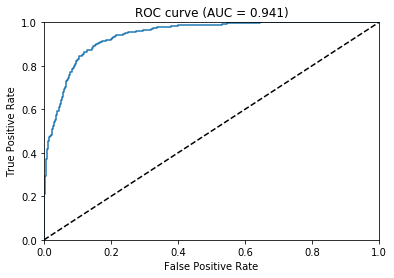

In [48]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [49]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.001982731046155095, recall = 1.0, precision = 0.4053819444444444
Threshold 0.0021563975606113672, recall = 0.9978586723768736, precision = 0.4098504837291117
Threshold 0.002478754846379161, recall = 0.9978586723768736, precision = 0.41532976827094475
Threshold 0.0027039265260100365, recall = 0.9978586723768736, precision = 0.4209575429087624
Threshold 0.002968168118968606, recall = 0.9978586723768736, precision = 0.4267399267399267
Threshold 0.003203503554686904, recall = 0.9957173447537473, precision = 0.43175487465181056
Threshold 0.003506479784846306, recall = 0.9957173447537473, precision = 0.4378531073446328
Threshold 0.004035271238535643, recall = 0.9957173447537473, precision = 0.44412607449856734
Threshold 0.004369161557406187, recall = 0.9935760171306209, precision = 0.4496124031007752
Threshold 0.004839712753891945, recall = 0.9892933618843683, precision = 0.45427728613569324
Threshold 0.00514603964984417, recall = 0.9892933618843683, precision = 0.461077844311377

AUC Score (Test): 0.878084


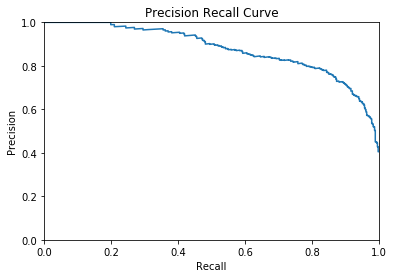

In [50]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.9902964  0.9111796  0.9971957  0.24748491 0.41916996]
467 1062
[660.  56.  28.  22.  16.  19.  21.   8.   8.   7.   7.  11.   8.   5.
   4.   6.   5.   4.   3.   4.   4.   6.   4.   7.   4.   8.   3.   1.
   6.   5.   2.   5.   2.   1.   3.   1.   3.   3.   3.   6.   5.   1.
   6.   3.   5.   5.   5.  14.  12.  27.]
[  9   5   3   2   1   3   4   1   4   3   2   0   2   2   1   2   1   1
   2   2   2   7   0   1   3   3   2   2   2   1   4   3   3   3   4   3
   3   5   3   3   6   7   6  12  11  11  15  26  29 144]


(0, 350)

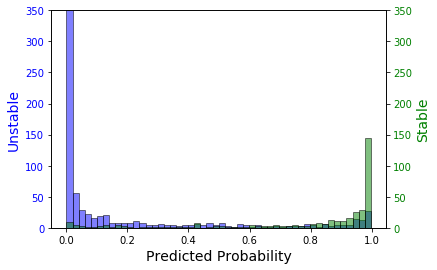

In [51]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

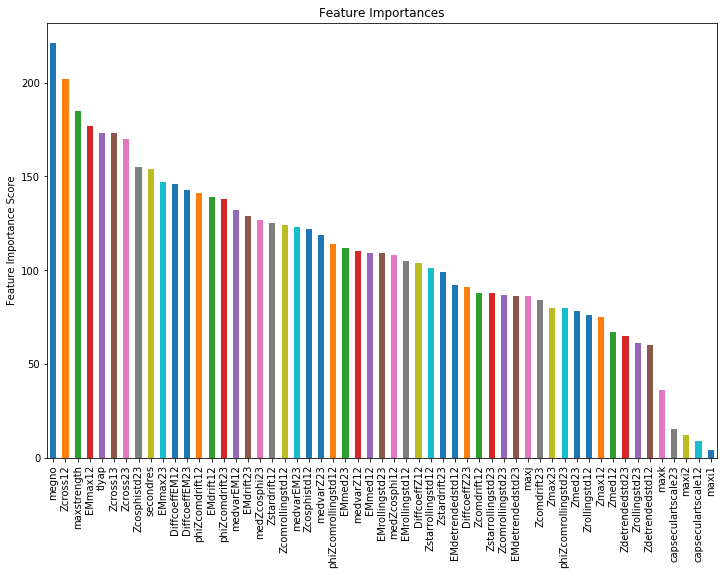

In [52]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [20]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/ressummaryfeaturesxgb_resonant.pkl", "wb"))